Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


Set all the Constants

In [3]:
BATCH_SIZE = 40
IMAGE_SIZE = 256
CHANNEL = 3
EPOCHS = 12

Import data into tensorflow dataset object


We will use image_dataset_from_directory api to load all images in tensorflow dataset:

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Classification_dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1600 files belonging to 8 classes.


In [5]:
class_name = dataset.class_names

In [6]:
class_name

['Anwar Ratool',
 'Chaunsa (Black)',
 'Chaunsa (Summer Bahisht)',
 'Chaunsa (White)',
 'Dosehri',
 'Fajri',
 'Langra',
 'Sindhri']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(40, 256, 256, 3)
[2 4 6 1 4 6 2 4 5 7 3 0 4 1 2 6 3 7 1 1 4 4 0 3 2 6 1 1 0 3 5 4 6 2 1 0 6
 4 2 7]


Visualize some of the images from our dataset

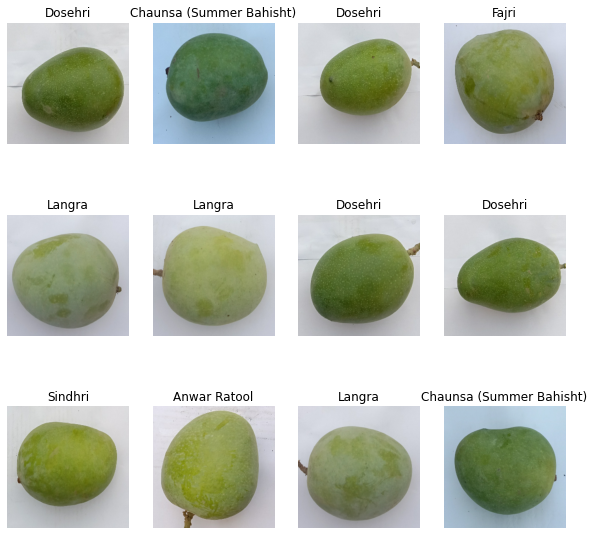

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

32.0

In [10]:
train_ds = dataset.take(32)
len(train_ds)

32

In [11]:
test_ds = dataset.skip(len(train_ds))
len(test_ds)

8

In [12]:
8*40+32*40

1600

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [13]:
def get_dataset_partitions_tf(ds , train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    assert(train_split+val_split+test_split)==1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds , test_ds

In [14]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)


32

In [16]:
len(val_ds)

4

In [17]:

len(test_ds)

4

Cache, Shuffle, and Prefetch the Dataset

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
for image_batch , labels_batch in dataset.take(1) :
    print(image_batch[0].numpy()/255)

[[[0.829542   0.8413067  0.86875767]
  [0.8281124  0.8398771  0.87016207]
  [0.8293996  0.8411643  0.8764584 ]
  ...
  [0.8371247  0.8488894  0.8841835 ]
  [0.83278954 0.84455425 0.87984836]
  [0.82928157 0.8410463  0.8763404 ]]

 [[0.83025706 0.84202176 0.86947274]
  [0.82845384 0.84021854 0.8705034 ]
  [0.827451   0.8392157  0.8745098 ]
  ...
  [0.8314737  0.8432384  0.8785326 ]
  [0.83679587 0.8485606  0.8838547 ]
  [0.83372396 0.84548867 0.8807828 ]]

 [[0.8232506  0.8350153  0.8624663 ]
  [0.8235294  0.8352941  0.86557907]
  [0.827451   0.8392157  0.8745098 ]
  ...
  [0.83014727 0.841912   0.8772061 ]
  [0.8361306  0.8478953  0.88318944]
  [0.8352941  0.84705883 0.88235295]]

 ...

 [[0.73035383 0.73819697 0.78525585]
  [0.7278876  0.7357307  0.7827895 ]
  [0.7214003  0.72924346 0.7763023 ]
  ...
  [0.7579121  0.76575524 0.8154259 ]
  [0.75852805 0.7663712  0.8160418 ]
  [0.7563955  0.76423866 0.81521904]]

 [[0.72739464 0.7352378  0.7822966 ]
  [0.73082876 0.7386719  0.7857307 ]


Building the Model

Creating a Layer for Resizing and Normalization

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Model Architecture

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. 


In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (40, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (40, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (40, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (40, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (40, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (40, 60, 60, 64)         

Compiling the Model

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
32/32 [==============================] - 111s 3s/step - loss: 3.1493 - accuracy: 0.1375 - val_loss: 2.0238 - val_accuracy: 0.2375
Epoch 2/15
32/32 [==============================] - 99s 3s/step - loss: 1.8420 - accuracy: 0.3562 - val_loss: 1.5316 - val_accuracy: 0.4313
Epoch 3/15
32/32 [==============================] - 95s 3s/step - loss: 1.4011 - accuracy: 0.4992 - val_loss: 0.9915 - val_accuracy: 0.6875
Epoch 4/15
32/32 [==============================] - 100s 3s/step - loss: 0.8534 - accuracy: 0.6938 - val_loss: 0.5005 - val_accuracy: 0.7937
Epoch 5/15
32/32 [==============================] - 94s 3s/step - loss: 0.5887 - accuracy: 0.7828 - val_loss: 1.3941 - val_accuracy: 0.5688
Epoch 6/15
32/32 [==============================] - 95s 3s/step - loss: 0.5175 - accuracy: 0.8219 - val_loss: 0.6320 - val_accuracy: 0.7500
Epoch 7/15
32/32 [==============================] - 94s 3s/step - loss: 0.3692 - accuracy: 0.8648 - val_loss: 0.3037 - val_accuracy: 0.9000
Epoch 8/15
32/32 [

In [26]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 8s 852ms/step - loss: 0.0480 - accuracy: 0.9875


You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [27]:
scores

[0.0480281338095665, 0.987500011920929]

Plotting the Accuracy and Loss Curves

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 32}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

15

In [33]:

history.history['loss'][:5] # show loss for first 5 epochs

[3.149275541305542,
 1.841965913772583,
 1.4010810852050781,
 0.8533915281295776,
 0.5887452363967896]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(range(EPOCHS), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

Run prediction on a sample image

first image to predict
actual label: Chaunsa (Summer Bahisht)
2/2 [==============================] - 1s 165ms/step
predicted label: Chaunsa (Summer Bahisht)


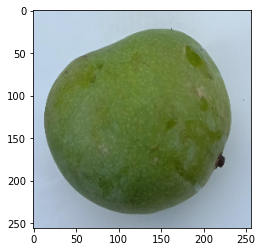

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

Write a function for inference

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 47ms/step


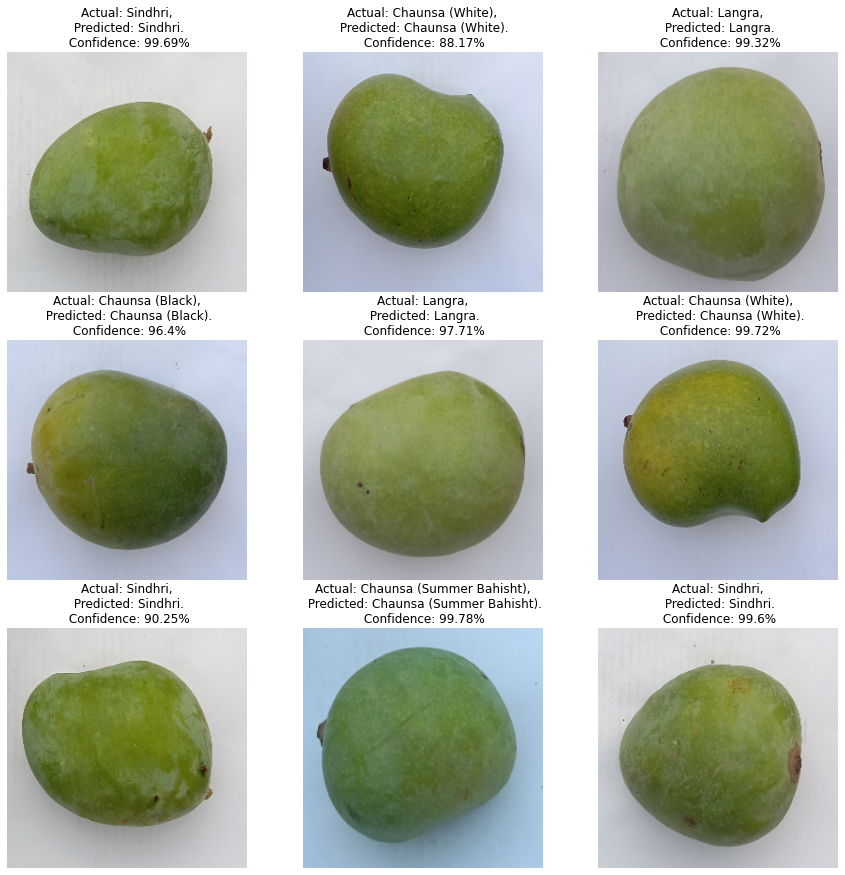

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

       

Saving the Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/6\assets


INFO:tensorflow:Assets written to: models/6\assets
